# 02. Word2Vec tensorflow

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Image

## Word2Vec (word to vector)
- 의미가 비슷한 단어는 벡터 공간에서 서로 가까운 위치에 존재하도록 변환하는 알고리즘
- 비지도학습으로 말뭉치 데이터만 있으면 쉽게 word2vec를 구할 수 있음 (label이 자동으로 생성되는 장점이 있음)

In [2]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

<hr>

## 전처리 - stop words 제거하기
- stop words: 학습에 도움이 되지도 않으면서 빈번하게 발생되는 단어

In [4]:
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be']
    result = []
    
    for text in corpus:
        tmp = text.split(' ')  # 띄어쓰기 기준으로 분류
        for stop_word in stop_words:
            if stop_word in tmp:      # stop_words 리스트에 있는 단어와 같다면 제거
                tmp.remove(stop_word)
                
        result.append(" ".join(tmp))
    return result

In [5]:
corpus = remove_stop_words(corpus)
corpus

['king strong man',
 'queen wise woman',
 'boy young man',
 'girl young woman',
 'prince young king',
 'princess young queen',
 'man strong',
 'woman pretty',
 'prince boy king',
 'princess girl queen']

In [7]:
# 전처리된 corpus 리스트 안의 문장만큼 반복 하면서 여백을 기준으로 단어 저장
words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)

# 집합 자료형에 담아 중복된 단어 제거
words = set(words)
words

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

<hr>

## 단어별 인덱스 매핑 테이블 만들기

In [9]:
word2int = {}
for i, word in enumerate(words):
    word2int[word] = i

word2int   # 말뭉치 == corpus == 자연어 처리의 input 데이터 == 단어 

{'young': 0,
 'man': 1,
 'queen': 2,
 'strong': 3,
 'boy': 4,
 'princess': 5,
 'pretty': 6,
 'woman': 7,
 'king': 8,
 'girl': 9,
 'prince': 10,
 'wise': 11}

<hr>

## label 생성
- skip gram 방식으로 각 단어별 레이블을 생성
- skip gram: 빈칸 집어넣기 (내 단어를 중심으로 앞뒤 단어 맞히기)
    - GPT: 다음 단어 맞히기
    - BERT: 단어 앞뒤 맞히기

In [10]:
sentences = []

for sentence in corpus:
    sentences.append(sentence.split())
    
WINDOW_SIZE = 2  # 앞 뒤로 두 단어씩을 정답 데이터로 만듦

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[
            max(idx - WINDOW_SIZE, 0): # 앞 뒤로 두 개씩 잘라냄
            min(idx + WINDOW_SIZE, len(sentence)) + 1]:
            if neighbor != word:
                data.append([word, neighbor])

In [11]:
# 데이터프레임으로 저장
df = pd.DataFrame(data, columns=['input', 'label']) # [입력, 정답]
df

# one-hot encoing은 유사성을 모두 0으로 만들기 때문에 유사성을 확인하기 위해 dataframe으로 변환

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


<hr>

## 텐서플로우로 word2vec 모델  구현하기

In [14]:
# 전체 단어의 수
ONE_HOT_DIM = len(words)
ONE_HOT_DIM

12

In [15]:
def to_one_hot_encoidng(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)        # np.zeros 배열의 공간을 모두 0으로 할당
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

In [16]:
X = []
Y = []

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoidng(word2int[x]))
    Y.append(to_one_hot_encoidng(word2int[y]))

In [18]:
# 원-핫 인코딩된 값을 배열에 저장
X_train = np.asarray(X)
Y_train = np.asarray(Y)

In [23]:
encoding_dim = 2

input_word = Input(shape=(ONE_HOT_DIM,))     # one-hot encoding으로 생성한 데이터의 길이가 input
encoded = Dense(encoding_dim,                # 출력의 수
                use_bias=False)(input_word) # 계산상의 편의를 위해 bias는 고려하지 않고 mapping
decoded = Dense(ONE_HOT_DIM, activation='softmax')(encoded)  # 다중 분류

In [24]:
w2v_model = Model(input_word, decoded)

In [25]:
w2v_model.compile(loss='categorical_crossentropy',
                 optimizer='adam')
# 현재 말뭉치의 단어가 최적에 가까운 w값 찾기

In [26]:
# 입력 12개, 출력 12개
w2v_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 12)                36        
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________


In [27]:
w2v_model.fit(X_train, Y_train,
              epochs=1000,
              shuffle=True,    # 학습할 때 입력데이터를 섞는 옵션 (과대적합 방지)
              verbose=0        # 학습 과정 출력 X 
             )

In [30]:
# 학습이 완료된 모델의 w값 확인 위해 word2vec 추출
vectors = w2v_model.layers[1].weights[0].numpy().tolist()
vectors

[[-0.03334778919816017, -0.22243952751159668],
 [0.013315088115632534, -1.5604771375656128],
 [-2.0791046619415283, 0.22907695174217224],
 [1.3709033727645874, -0.8717326521873474],
 [0.5832464098930359, -0.9262727499008179],
 [-0.5666799545288086, 1.4999858140945435],
 [-1.7391055822372437, 0.3775179386138916],
 [-0.1819569617509842, 1.4412164688110352],
 [0.7293712496757507, -1.3188012838363647],
 [-1.2055474519729614, 0.40385323762893677],
 [-0.5223424434661865, -1.303774356842041],
 [-0.7615867257118225, 0.982042133808136]]

<hr>

## word2vec의 좌표값
- 2d 차트에서 각 단어의 좌표값을 볼 수 있음

In [34]:
w2v_df = pd.DataFrame(vectors, columns=['x1', 'x2'])
w2v_df['word'] = list(words)              # words에 있는 단어를 담은 열 생성
w2v_df = w2v_df[['word', 'x1', 'x2']]              # feature의 순서 변경
w2v_df

,word,x1,x2
0,young,-0.033348,-0.222440
1,man,0.013315,-1.560477
2,queen,-2.079105,0.229077
3,strong,1.370903,-0.871733
4,boy,0.583246,-0.926273
5,princess,-0.566680,1.499986
6,pretty,-1.739106,0.377518
7,woman,-0.181957,1.441216
8,king,0.729371,-1.318801
9,girl,-1.205547,0.403853


<hr>

## word2vec를 2차원 공간 상에 시각화

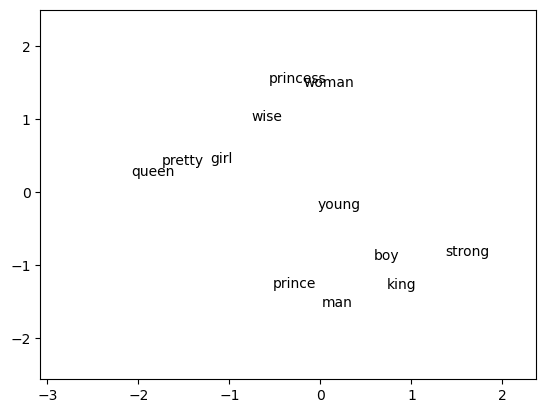

In [40]:
fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1, x2))

PADDING = 1.0  # 그래프에서 여유공간을 만들기 위해 padding 설정
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING

plt.xlim(x_axis_min, x_axis_max)
plt.ylim(y_axis_min, y_axis_max)
plt.rcParams['figure.figsize'] = [9, 9]